In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

In [2]:
# IN ORDER TO CENTER ALL THE GRAPHS 
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:
# IN ORDER TO SUPRESS SOME WARNING WHILE USING KNN 
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# <center>Tasks</center>

<center><img src="Images/Assignment_2_Tasks.png" width="600" title="Tasks"></center>

# <center>Tratamento de Dados</center>

In [4]:
df = pd.read_csv('video_games.csv')

In [5]:
# DataFrame 
df.head(3)

,id,name,category,n_dlcs,n_expansions,year,follows,in_franchise,genres,companies,platforms,user_score,user_rating,n_user_reviews,summary
0,1020,Grand Theft Auto V,main_game,0,0,2013,1766,True,"Shooter, Adventure","Rockstar North, Rockstar Games, Take-Two Inter...","PC (Microsoft Windows), PlayStation 3, Xbox 36...",90.202388,great,3369,Grand Theft Auto V is a vast open world game s...
1,1942,The Witcher 3: Wild Hunt,main_game,4,2,2015,1516,True,"Role-playing (RPG), Adventure","WB Games, Bandai Namco Entertainment, cdp.pl, ...","PC (Microsoft Windows), PlayStation 4, Xbox On...",95.169577,great,2997,"RPG and sequel to The Witcher 2 (2011), The Wi..."
2,472,The Elder Scrolls V: Skyrim,main_game,3,0,2011,1046,False,"Role-playing (RPG), Adventure","Bethesda Game Studios, Bethesda Softworks","PC (Microsoft Windows), PlayStation 3, Xbox 360",87.508504,great,2567,Skyrim reimagines and revolutionizes the open-...


In [6]:
# Info do DataFrame 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5824 entries, 0 to 5823
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              5824 non-null   int64  
 1   name            5824 non-null   object 
 2   category        5824 non-null   object 
 3   n_dlcs          5824 non-null   int64  
 4   n_expansions    5824 non-null   int64  
 5   year            5824 non-null   int64  
 6   follows         5824 non-null   int64  
 7   in_franchise    5824 non-null   bool   
 8   genres          5803 non-null   object 
 9   companies       5781 non-null   object 
 10  platforms       5824 non-null   object 
 11  user_score      5824 non-null   float64
 12  user_rating     5824 non-null   object 
 13  n_user_reviews  5824 non-null   int64  
 14  summary         5816 non-null   object 
dtypes: bool(1), float64(1), int64(6), object(7)
memory usage: 642.8+ KB


In [7]:
# Remoção de Colunas Desnecessárias 
del df["summary"]
del df["id"]
del df["category"]
df.head(3)

,name,n_dlcs,n_expansions,year,follows,in_franchise,genres,companies,platforms,user_score,user_rating,n_user_reviews
0,Grand Theft Auto V,0,0,2013,1766,True,"Shooter, Adventure","Rockstar North, Rockstar Games, Take-Two Inter...","PC (Microsoft Windows), PlayStation 3, Xbox 36...",90.202388,great,3369
1,The Witcher 3: Wild Hunt,4,2,2015,1516,True,"Role-playing (RPG), Adventure","WB Games, Bandai Namco Entertainment, cdp.pl, ...","PC (Microsoft Windows), PlayStation 4, Xbox On...",95.169577,great,2997
2,The Elder Scrolls V: Skyrim,3,0,2011,1046,False,"Role-playing (RPG), Adventure","Bethesda Game Studios, Bethesda Softworks","PC (Microsoft Windows), PlayStation 3, Xbox 360",87.508504,great,2567


In [8]:
# Agrupamento/Categorização dos Atributos 
# Categorical Columns/Attributes
cat_columns = ['name',
              'genres',
              'companies',
              'platforms',
              'user_rating']

# Numerical Columns/Attributes
num_columns = ['n_dlcs',
               'n_expansions',
               'year',
               'follows',
               'user_score',
               'n_user_reviews']
df.dtypes

name               object
n_dlcs              int64
n_expansions        int64
year                int64
follows             int64
in_franchise         bool
genres             object
companies          object
platforms          object
user_score        float64
user_rating        object
n_user_reviews      int64
dtype: object

In [9]:
# Atributos que apresentam NaN values 
print(f"Atributo\t  Contem NaN?\n")
print(df.isna().any())

Atributo	  Contem NaN?

name              False
n_dlcs            False
n_expansions      False
year              False
follows           False
in_franchise      False
genres             True
companies          True
platforms         False
user_score        False
user_rating       False
n_user_reviews    False
dtype: bool


In [10]:
# Remoção de Valores Repetidos ou NaN 

df.drop_duplicates(inplace=True)
df.dropna(how='any', axis=0, inplace=True)

In [11]:
# Conversão de Str to List de Alguns Atributos 

Attributes_Str_To_List = ['genres', 'companies', 'platforms']
for i in Attributes_Str_To_List:
    df[i] = df[i].str.split(", ")

for k in Attributes_Str_To_List:
    print(f"\t\tAttribute: {k}\n")
    print(df[k].head(3))
    print()

		Attribute: genres

0               [Shooter, Adventure]
1    [Role-playing (RPG), Adventure]
2    [Role-playing (RPG), Adventure]
Name: genres, dtype: object

		Attribute: companies

0    [Rockstar North, Rockstar Games, Take-Two Inte...
1    [WB Games, Bandai Namco Entertainment, cdp.pl,...
2          [Bethesda Game Studios, Bethesda Softworks]
Name: companies, dtype: object

		Attribute: platforms

0    [PC (Microsoft Windows), PlayStation 3, Xbox 3...
1    [PC (Microsoft Windows), PlayStation 4, Xbox O...
2    [PC (Microsoft Windows), PlayStation 3, Xbox 360]
Name: platforms, dtype: object



In [12]:
# Conversão do Atributo 'In_Franchise' para int 
# (True -> 1 || False -> 0)

atr = "in_franchise"
df[atr] = df[atr].apply(lambda x: x==True).astype('int64')
num_columns.append(atr)
df[atr].head(3)

0    1
1    1
2    0
Name: in_franchise, dtype: int64

In [13]:
# NEW ATTRIBUTE -> AGE
df.insert(4, 'age', 2023-df['year'])
num_columns.append('age')

In [14]:
# NEW ATTRIBUTE -> N_GENRES
df.insert(8, 'n_genres', df['genres'].apply(lambda x: len(x)))
num_columns.append('n_genres')

In [15]:
# NEW ATTRIBUTE -> N_COMPANIES
df.insert(10, 'n_companies', df['companies'].apply(lambda x: len(x)))
num_columns.append('n_companies')

In [16]:
# NEW ATTRIBUTE -> N_PLATFORMS
df.insert(12, 'n_platforms', df['platforms'].apply(lambda x: len(x)))
num_columns.append('n_platforms')
df.head(3)

,name,n_dlcs,n_expansions,year,age,follows,in_franchise,genres,n_genres,companies,n_companies,platforms,n_platforms,user_score,user_rating,n_user_reviews
0,Grand Theft Auto V,0,0,2013,10,1766,1,"[Shooter, Adventure]",2,"[Rockstar North, Rockstar Games, Take-Two Inte...",3,"[PC (Microsoft Windows), PlayStation 3, Xbox 3...",7,90.202388,great,3369
1,The Witcher 3: Wild Hunt,4,2,2015,8,1516,1,"[Role-playing (RPG), Adventure]",2,"[WB Games, Bandai Namco Entertainment, cdp.pl,...",6,"[PC (Microsoft Windows), PlayStation 4, Xbox O...",4,95.169577,great,2997
2,The Elder Scrolls V: Skyrim,3,0,2011,12,1046,0,"[Role-playing (RPG), Adventure]",2,"[Bethesda Game Studios, Bethesda Softworks]",2,"[PC (Microsoft Windows), PlayStation 3, Xbox 360]",3,87.508504,great,2567



## <center>Visualização de Dados</center>

<AxesSubplot:xlabel='year', ylabel='user_score'>

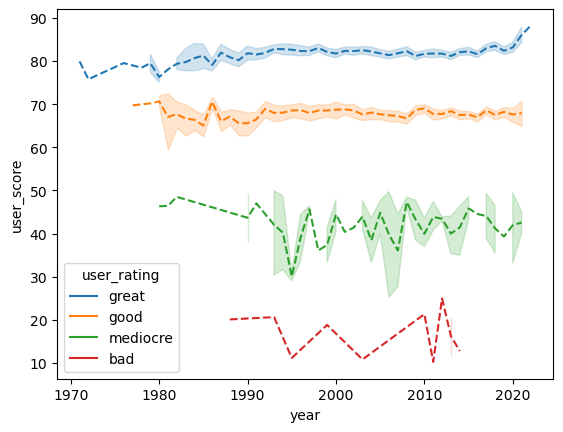

In [17]:
sns.lineplot(data=df,
             x='year',
             y='user_score',
             hue='user_rating',
             linestyle='--')

<AxesSubplot:xlabel='year', ylabel='n_platforms'>

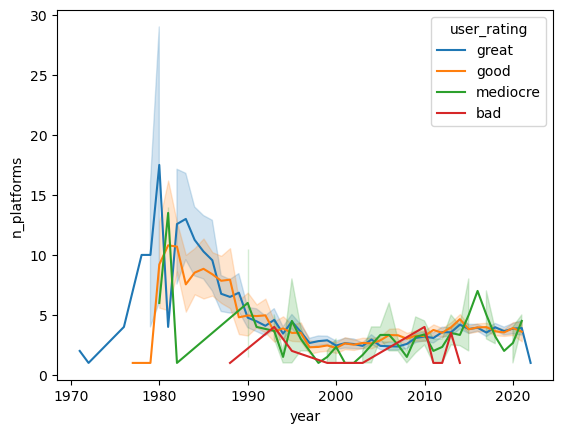

In [18]:
sns.lineplot(data=df,
             x='year',
             y='n_platforms',
             hue='user_rating')

# <center> Análise e Criação de Modelos Preditivos </center>

## <center>Funções Auxiliares</center>

In [19]:
# Generic Functions to Analyse the Predictive Models
# Decision Tree Functions
def Analyse_Predictive_Model_DT(X, Y, n, test_size):
    model_accuracies = []
    for _ in range (n):
        (X_train, X_test,
         Y_train, Y_test) = train_test_split(X, Y, test_size=test_size)
        model = DecisionTreeClassifier()
        model.fit(X_train, Y_train)
        model_accuracies.append(model.score(X_test,Y_test))
    return model_accuracies

def Plot_Average_Score_Histogram_DT(X, Y, n, test_size, color):
    model_accuracies = Analyse_Predictive_Model_DT(X,Y,n,test_size)
    plt.hist(model_accuracies, color=color)
    plt.title(f"Average Score (DT): {np.mean(model_accuracies)*100: .5f}")
    plt.xlabel('Score (%)')
    plt.ylabel('Nº of Cases')
    plt.grid(visible=True, linestyle='dashed', linewidth=1.2)
    plt.show()
    
def Save_Tree_Diagram(File_Name, Model):
    with open(f'{File_Name}.dot', 'w') as out_file:
        out_file = tree.export_graphviz(Model, out_file=out_file)

# KNN Functions
def Analyse_Predictive_Model_KNN(X, Y, n, test_size, num_neighbors):
    model_accuracies = []
    for _ in range (n):
        (X_train, X_test,
         Y_train, Y_test) = train_test_split(X, Y, test_size=test_size)
        model = KNeighborsClassifier(n_neighbors=num_neighbors)
        model.fit(X_train, Y_train)
        model_accuracies.append(model.score(X_test,Y_test))
    return model_accuracies

def Plot_Average_Score_Histogram_KNN(X, Y, n, test_size, num_neighbors, color):
    model_accuracies = Analyse_Predictive_Model_KNN(X,Y,n,test_size,num_neighbors)
    plt.hist(model_accuracies, color=color)
    plt.title(f"Average Score (KNN): {np.mean(model_accuracies)*100: .5f}")
    plt.xlabel('Score (%)')
    plt.ylabel('Nº of Cases')
    plt.grid(visible=True, linestyle='dashed', linewidth=1.2)
    plt.show()

# Cross Validation Functions
def Plot_Model_Cross_Validation(model_name, model,X,Y,color):
    # cross_val_score returns a list of the scores, which we can visualize
    # to get a reasonable estimate of our classifier's performance
    kfold = KFold(n_splits=10)
    model_cross_validation_scores = cross_val_score(model,X,Y,cv=kfold)
    print(f"-> {model_name} Accuracy Avg: {model_cross_validation_scores.mean()*100:.3f} (Std: {model_cross_validation_scores.std()*100:.3f})\n")
    plt.hist(model_cross_validation_scores, color=color)
    plt.title(f'{model_name} -> Average Accuracy (%): {np.mean(model_cross_validation_scores)*100: .5f}')
    plt.grid(visible=True, linestyle='dashed', linewidth=1.2)
    plt.show()
    return model_cross_validation_scores

# Confusion Matrix
def Plot_Confusion_Matrix(Test_Values, Predicted_Values, labels):
    Confusion_Matrix = confusion_matrix(Test_Values,
                                        Predicted_Values,
                                        labels=labels)
    Display = ConfusionMatrixDisplay(confusion_matrix=Confusion_Matrix,
                                    display_labels=labels)
    Display.plot(cmap=plt.cm.Blues)
    plt.show()

In [20]:
# Functions to get the best classifier for each algorithm
def Find_Best_DT_Classifier(X,Y,stratigy=None):
    # stratigy - way to evaluate the performance of the cross-validated model on the test set
    DT_classifier = DecisionTreeClassifier()
    parameter_grid = {'criterion': ['gini', 'entropy'],
                      'splitter': ['best', 'random'],
                      'max_depth':[1,2,3,4,5],
                     'max_features':[1,2,3,4]}

    cross_validation = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(DT_classifier,
                              param_grid=parameter_grid,
                              cv=cross_validation,
                              scoring=stratigy)

    grid_search.fit(X,Y)
    print(f"Best Score (%):\n  -> {grid_search.best_score_*100:.4f}")

    print(f"Best Parameters:")
    for param in grid_search.best_params_:
        print(f"  -> {param} = {grid_search.best_params_[param]}")
    
    DT_classifier = grid_search.best_estimator_
    return DT_classifier

def Find_Best_KNN_Classifier(X, Y, num_neighbors, stratigy=None):
    KNN_Classifier = KNeighborsClassifier(n_neighbors=num_neighbors)
    parameter_grid = {'n_neighbors': (1,10, 1),
                      'leaf_size': (20,40,1),
                      'p': (1,2),
                      'weights': ('uniform', 'distance'),
                      'metric': ('minkowski', 'chebyshev')},

    cross_validation = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(KNN_Classifier,
                              param_grid=parameter_grid,
                              cv=cross_validation,
                              scoring=stratigy)

    grid_search.fit(X,Y)
    print(f"Best Score (%):\n  -> {grid_search.best_score_*100:.4f}")
    print(f"Best Parameters:")
    for param in grid_search.best_params_:
        print(f"  -> {param} = {grid_search.best_params_[param]}")
    
    KNN_Classifier = grid_search.best_estimator_
    return KNN_Classifier


## <center>Previsão do 'User_Rating' (Decision Tree & KNN) </center>

### Criação de subsets para treino e teste de modelos preditivos

In [21]:
X = df.drop(columns=cat_columns)
Y = df['user_rating']

(X_train, X_test,
 Y_train, Y_test) = train_test_split(X, Y, test_size=0.3)

## <center>Decision Tree Classifier</center>

In [22]:
# Decision Tree Classifier
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
;

''

In [23]:
# Decision Tree - Test Predictions
decision_tree_predicted = decision_tree.predict(X_test)
total_guesses = decision_tree_predicted.shape[0]
correct_guesses = ((decision_tree_predicted == Y_test) == True).sum()
incorrect_guesses = ((decision_tree_predicted == Y_test) == False).sum()

print(f"Previsões Corretas: {correct_guesses}/{total_guesses}")
print(f"Previsões Incorretas: {incorrect_guesses}/{total_guesses}")

Previsões Corretas: 1728/1729
Previsões Incorretas: 1/1729


In [24]:
# Decision Tree - Train and Test Accuracies

decision_tree_acc_train = decision_tree.score(X_train, Y_train)
decision_tree_acc_test = decision_tree.score(X_test, Y_test)

print(f"Decision Tree Train Accuracy (%): {decision_tree_acc_train*100:.4f}")
print(f"Decision Tree Test Accuracy (%): {decision_tree_acc_test*100:.4f}")

Decision Tree Train Accuracy (%): 100.0000
Decision Tree Test Accuracy (%): 99.9422


In [25]:
# In order to save the Decision Tree
Save_Tree_Diagram("Decision_Tree_Model",decision_tree)

### <center>Decision Tree - Diagram</center>

<center><img src="Decision_Tree_Model.png" width="600" title="Decision Tree"></center>

##  <center>KNN Classifier</center>

In [26]:
# KNN Classifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,Y_train)
;

''

In [27]:
# KNN - Test Predictions
knn_preds_test = knn.predict(X_test)
total_guesses = knn_preds_test.shape[0]
correct_guesses = ((knn_preds_test == Y_test) == True).sum()
incorrect_guesses = ((knn_preds_test == Y_test) == False).sum()

print(f"Previsões Corretas: {correct_guesses}/{total_guesses}")
print(f"Previsões Incorretas: {incorrect_guesses}/{total_guesses}")

Previsões Corretas: 1623/1729
Previsões Incorretas: 106/1729


In [28]:
# KNN Accuracies - Train and Test Accuracies

knn_preds_train = knn.predict(X_train)
knn_acc_train = sum(knn_preds_train == Y_train) / len(Y_train)
# Equivalente a:
knn_acc_train = knn.score(X_train, Y_train)

knn_preds_test = knn.predict(X_test)
knn_acc_test = sum(knn_preds_test == Y_test) / len(Y_test)
# Equivalente a:
knn_acc_test = knn.score(X_test,Y_test)

print(f"KNN Train Accuracy (%): {knn_acc_train*100:.4f}")
print(f"KNN Test Accuracy (%): {knn_acc_test*100:.4f}")

KNN Train Accuracy (%): 96.4038
KNN Test Accuracy (%): 93.8693


## <center>Comparação dos Modelos Preditivos</center>

### <center>Confusion Matrix</center>

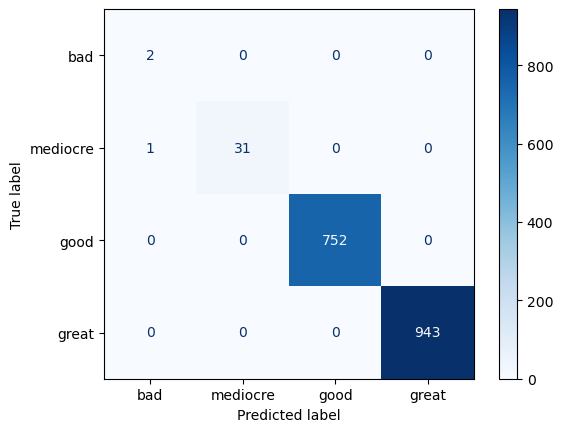

In [29]:
# Confusion Matrix - Decision Tree 
Plot_Confusion_Matrix(Y_test, 
                      decision_tree_predicted,
                      labels=['bad', 'mediocre', 'good', 'great'])

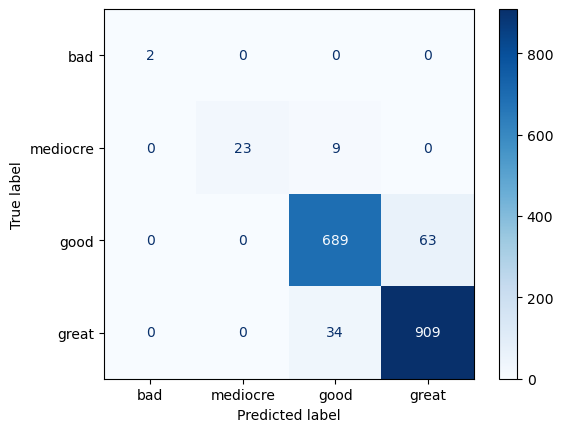

In [30]:
# Confusion Matrix - KNN 
Plot_Confusion_Matrix(Y_test,
                      knn_preds_test,
                      labels=['bad', 'mediocre', 'good', 'great'])

### <center>Precision, Recall, Accuracy</center>

In [31]:
# Precision, Recall and Accuracy given the predictive models obtained (single train and test subsets) 
data = [
        [precision_score(Y_test,decision_tree_predicted,average='macro')*100,
         recall_score(Y_test,decision_tree_predicted,average='macro')*100,
         accuracy_score(Y_test,decision_tree_predicted)*100],
        
        [precision_score(Y_test,knn_preds_test,average='macro')*100,
         recall_score(Y_test,knn_preds_test,average='macro')*100,
         accuracy_score(Y_test,knn_preds_test)*100]
       ]

Evaluation_df = pd.DataFrame(data,
                             columns=['Precision (%)',
                                      'Recall/Sensitivity (%)',
                                      'Accuracy (%)'],
                             index=['Decision Tree', 'KNN'])
Evaluation_df

,Precision (%),Recall/Sensitivity (%),Accuracy (%)
Decision Tree,91.666667,99.218750,99.942163
KNN,96.911050,89.972957,93.869289


### <center>Performance (Using Cross Validation)</center>

### <center>Without K-Fold</center>

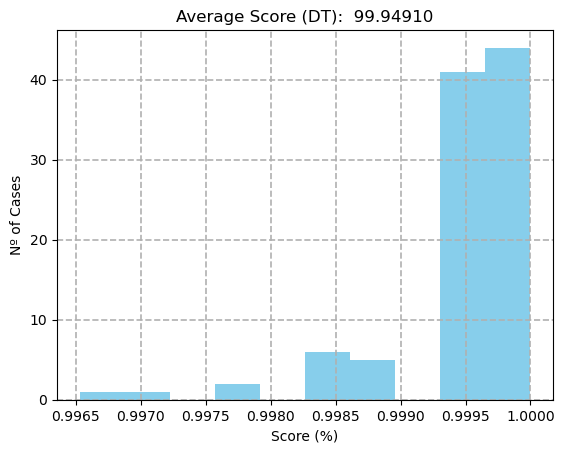

In [32]:
# DT Average Score/Accuracy 
# (Cross Validation Without Kfold - without a normal distribution)
Plot_Average_Score_Histogram_DT(X,Y,100,0.3,"skyblue")

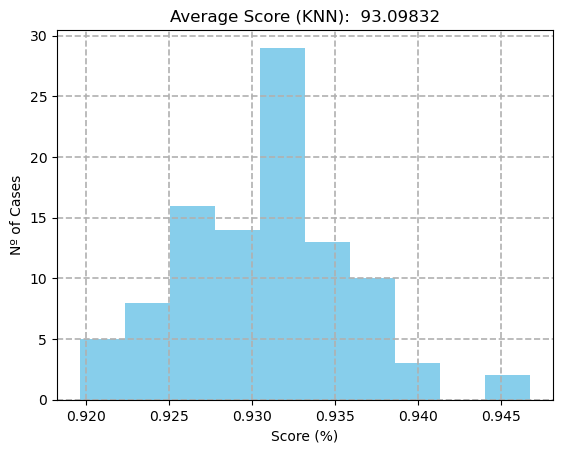

In [33]:
# KNN Average Score/Accuracy 
# (Cross Validation Without Kfold - without a normal distribution)
Plot_Average_Score_Histogram_KNN(X,Y,100,0.3,3,"skyblue")

### <center>With K-Fold</center>

-> Decision Tree Accuracy Avg: 99.965 (Std: 0.069)



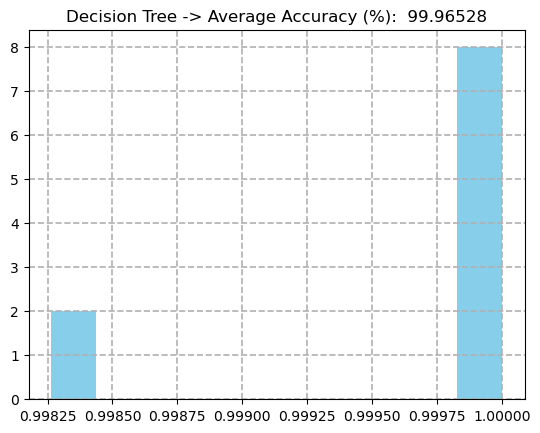

In [34]:
# DT Average Score/Accuracy 
# (Cross Validation With Kfold - with a normal distribution)
DT_CV_Scores = Plot_Model_Cross_Validation("Decision Tree",decision_tree,X,Y,"skyblue")

-> KNN Accuracy Avg: 90.404 (Std: 7.666)



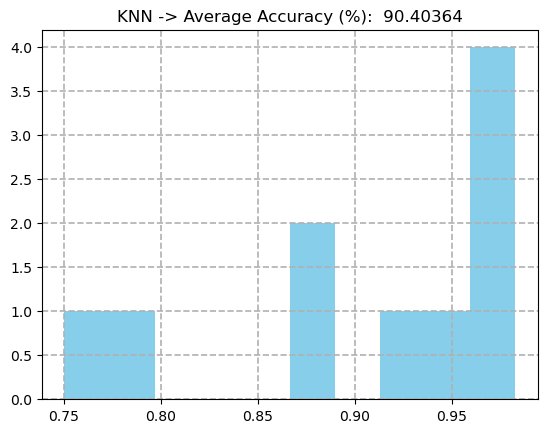

In [35]:
# KNN Average Score/Accuracy 
# (Cross Validation With Kfold - with a normal distribution)
KNN_CV_Scores = Plot_Model_Cross_Validation("KNN",knn,X,Y,"skyblue")

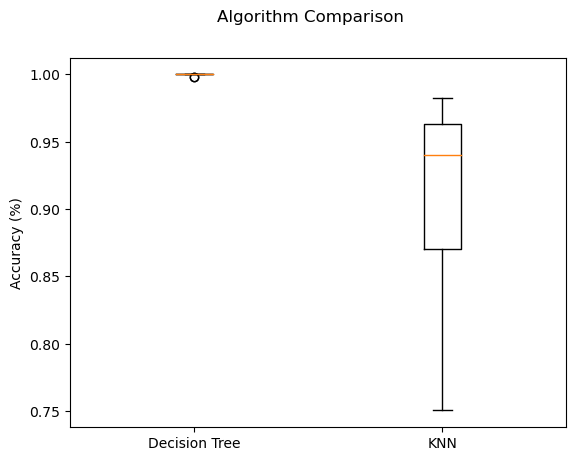

In [36]:
# Simple BoxPlot with both algorithm's accuracies (calculated above)
X_labels = ['Decision Tree', 'KNN']
Y_label = 'Accuracy (%)'
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot([DT_CV_Scores, KNN_CV_Scores])
ax.set_xticklabels(X_labels)
plt.ylabel(Y_label)
plt.show()

# <center>Parameter Tunning (Grid Search)</center>

## <center>Decision Tree Classifier</center>

In [37]:
# Finding the Best Possible Configuration for the DT_Classifier 
decision_tree = Find_Best_DT_Classifier(X,Y)
Save_Tree_Diagram("Best_DT_Classifier", decision_tree)

Best Score (%):
  -> 98.2648
Best Parameters:
  -> criterion = gini
  -> max_depth = 4
  -> max_features = 4
  -> splitter = best


### - Decision Tree Diagram

<center><img src="Best_Decision_Tree_Model.png" width="2000" title="Decision Tree"></center>

## <center>KNN Classifier</center>

In [38]:
# Finding the Best Possible Configuration for the KNN_Classifier 
knn = Find_Best_KNN_Classifier(X,Y,num_neighbors=3)

Best Score (%):
  -> 72.8374
Best Parameters:
  -> leaf_size = 20
  -> metric = minkowski
  -> n_neighbors = 10
  -> p = 1
  -> weights = distance
